In [59]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [60]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses_cleaned.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,Private Pool,zip,price
0,3.0,1758.0,7150.0,2.0,0,1.0,1978.0,False,77084,221000.0
1,4.0,2958.0,9400.0,3.0,1,2.0,1980.0,False,77070,359500.0
2,3.0,1120.0,6000.0,2.0,0,1.0,1936.0,False,77008,825000.0
3,3.0,1714.0,5500.0,2.0,0,1.0,1986.0,False,77095,289995.0
4,2.0,1180.0,6960.0,1.0,0,1.0,1955.0,False,77033,128000.0


In [61]:
data.describe()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,zip,price
count,31331.000000,31331.000000,3.133100e+04,31331.000000,31331.000000,31331.000000,31331.000000,31331.000000,3.133100e+04
mean,3.548115,2382.059270,1.127894e+04,2.404583,0.511315,1.524319,2001.032205,77345.959146,4.950054e+05
std,0.864415,1122.423208,4.512432e+04,0.825262,0.561868,0.588196,49.779377,334.488159,5.750877e+05
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,71075.000000,1.000000e+00
25%,3.000000,1685.000000,1.667500e+03,2.000000,0.000000,1.000000,1984.000000,77089.000000,2.875000e+05
50%,4.000000,2182.000000,6.395000e+03,2.000000,0.000000,1.000000,2011.000000,77379.000000,3.750000e+05
75%,4.000000,2826.000000,8.800000e+03,3.000000,1.000000,2.000000,2022.000000,77493.000000,5.290000e+05
max,11.000000,30717.000000,1.441410e+06,9.000000,9.000000,5.000000,2022.000000,78950.000000,2.650000e+07


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31331 entries, 0 to 31330
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31331 non-null  float64
 1   Sqft.         31331 non-null  float64
 2   lot Sqft.     31331 non-null  float64
 3   full baths    31331 non-null  float64
 4   half baths    31331 non-null  int64  
 5   stories       31331 non-null  float64
 6   year built    31331 non-null  float64
 7   Private Pool  31331 non-null  bool   
 8   zip           31331 non-null  int64  
 9   price         31331 non-null  float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 2.2 MB


In [63]:
# Convert zip to string to make it a categorical feature

data['zip'] = data['zip'].astype('str')

In [64]:
def reduceZip(df, how='median', bins=5):
    """
    Accepts: dataframe, number of bins and which stat to groupby
    Returns: dataframe with new column categorizing zipcodes by price
    """
    zipGrouped = df[['zip', 'price']].groupby(['zip']).median() if how == 'median' else df.groupby(['zip']).mean()
    zipGrouped['zipTier'] = pd.cut(zipGrouped['price'], bins=bins, labels=False)
    zipGrouped = zipGrouped.drop(['price'], axis=1)
    return df.merge(zipGrouped, how='left', on='zip')

data = reduceZip(data)

In [65]:
# Convert year built to "age" of home

data['age'] = data.apply(lambda x: 2022 - x['year built'] + 1 if x['year built'] else 0, axis=1)
data = data.drop(['year built'], axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,Private Pool,zip,price,zipTier,age
0,3.0,1758.0,7150.0,2.0,0,1.0,False,77084,221000.0,0,45.0
1,4.0,2958.0,9400.0,3.0,1,2.0,False,77070,359500.0,0,43.0
2,3.0,1120.0,6000.0,2.0,0,1.0,False,77008,825000.0,1,87.0
3,3.0,1714.0,5500.0,2.0,0,1.0,False,77095,289995.0,0,37.0
4,2.0,1180.0,6960.0,1.0,0,1.0,False,77033,128000.0,0,68.0


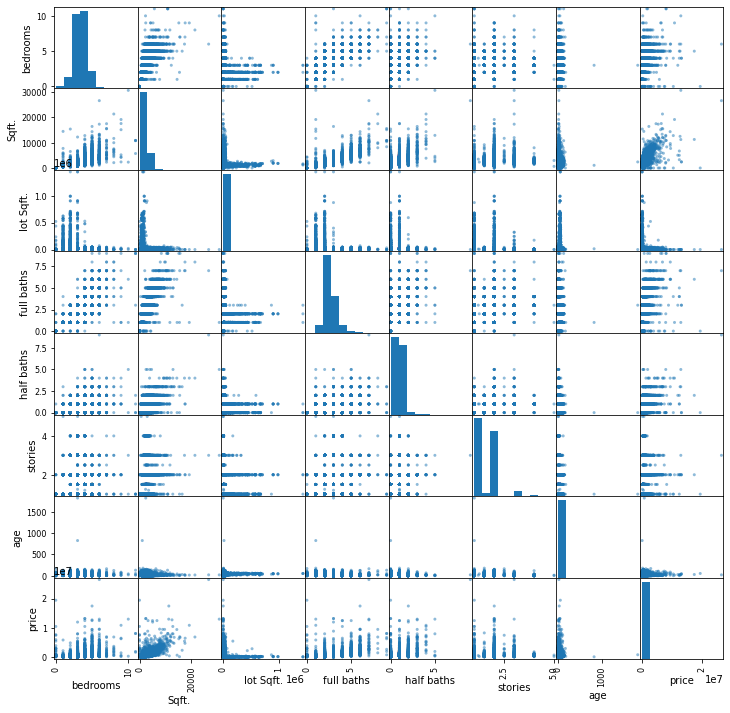

In [66]:
cat_col = ['zip', 'Private Pool', 'zipTier']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age', 'price']
scatter_matrix(data[num_col], figsize=(12, 12))
plt.show()

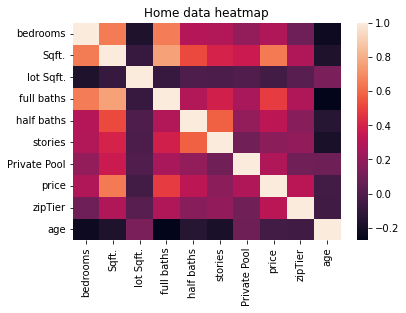

In [67]:
corr = data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Home data heatmap')
plt.show()

In [68]:
X = data.drop(['price', 'zip'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.columns)

Index(['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories',
       'Private Pool', 'zipTier', 'age'],
      dtype='object')


In [69]:
cat_col = ['zipTier', 'Private Pool']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']

def prepareXData(x_data, dropFirst=False):
    """
    Accepts: training data and whether or not to drop the first category in OHE
    Returns: prepared data
    """
    num_pipeline = Pipeline([
            ('std_scaler', StandardScaler())
        ])
    cat_pipeline = Pipeline([
        ('OHE_drop_first', OneHotEncoder())
    ])
    cat_pipe_drop_first = Pipeline([
        ('OHE_drop_first', OneHotEncoder(drop='first'))
    ])

    full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_col),
            ("cat", cat_pipe_drop_first if dropFirst else cat_pipeline, cat_col),
        ])
    return full_pipeline
l1_pipeline = prepareXData(X_train, dropFirst=True)
l2_pipeline = prepareXData(X_train, dropFirst=False)

X_train_prep, X_test_prep = l1_pipeline.fit_transform(X_train), l1_pipeline.transform(X_test)
X_train_prep_dropped_first, X_test_prep_dropped_first = l2_pipeline.fit_transform(X_train), l2_pipeline.transform(X_test)

In [70]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prep, y_train)

lin_reg_dropped_first = LinearRegression()
lin_reg_dropped_first.fit(X_train_prep_dropped_first, y_train)

LinearRegression()

In [71]:
print(lin_reg.score(X_train_prep, y_train), lin_reg_dropped_first.score(X_train_prep_dropped_first, y_train))

0.49284351633399126 0.49283280864498813


In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

parameters = {'alpha':(.1, 1, 10, 100), 
              'fit_intercept':(True, False),
              'solver': ('auto', 'lsqr')}

ridge_reg = Ridge()
gs = GridSearchCV(ridge_reg, parameters)
gs.fit(X_train_prep_dropped_first, y_train)

gs.best_params_


{'alpha': 10, 'fit_intercept': True, 'solver': 'auto'}

In [73]:
ridge_regression = Ridge(alpha=1, fit_intercept=False, solver='auto')
ridge_regression.fit(X_train_prep, y_train)
print(f'Score without dropping first cat col: {ridge_regression.score(X_train_prep, y_train)}')

ridge_regression.fit(X_train_prep_dropped_first, y_train)
print(f'Score with dropping first cat col: {ridge_regression.score(X_train_prep_dropped_first, y_train)}')

Score without dropping first cat col: 0.22446403233169332
Score with dropping first cat col: 0.492843000931377


In [74]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=10.0, max_iter=3000, selection='random')
lasso_reg.fit(X_train_prep, y_train)
lasso_reg.score(X_train_prep, y_train)

0.49284339968070023

In [75]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                bootstrap=True,
                                n_jobs=1, 
                                random_state=42).fit(X_train_prep_dropped_first, y_train)
forest.score(X_test_prep_dropped_first, y_test)   

0.5669020086982269

In [76]:
print(f'coef of determination = {forest.score(X_test_prep_dropped_first, y_test)}')
print(f'MAE = {mean_squared_error(y_test, forest.predict(X_test_prep_dropped_first))}')

coef of determination = 0.5669020086982269
MAE = 136640723380.92009


In [77]:
from sklearn.svm import SVR

svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)

svr_rbf.fit(X_train_prep, y_train)
svr_lin.fit(X_train_prep, y_train)
svr_poly.fit(X_train_prep, y_train)

SVR(C=100, coef0=1, gamma='auto', kernel='poly')

In [78]:
rbf_score = svr_rbf.score(X_train_prep, y_train)
lin_score = svr_lin.score(X_train_prep, y_train)
poly_score = svr_poly.score(X_train_prep, y_train)

print(rbf_score, lin_score, poly_score)

0.0422916197535278 0.31390674764316495 0.4751842125172222


pca, partial corelation, feature importance, partial dependance plot, remove outliers explicitly, bedroom/story to calculate outliers